In [2]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import mnist

Populating the interactive namespace from numpy and matplotlib


Load MNIST dataset and convert result to numpy arrays

In [14]:
(trainX, trainY), (testX, testY) = mnist.load_data()
train_samples = trainX.shape[0]
test_samples = testX.shape[0]

trainX = trainX.reshape((train_samples, 28*28))
testX = testX.reshape((test_samples, 28*28))
trainY = keras.utils.to_categorical(trainY, num_classes=10)

First let's create multiple layer perceptron

In [48]:
mlp_model = Sequential([
    Dense(64, input_shape=(784,), kernel_initializer='random_uniform'),
    Activation('relu'),
    Dropout(0.125),
    Dense(64, kernel_initializer='random_uniform'),
    Activation('relu'),
    Dense(10, kernel_initializer='random_uniform'),
    Activation('softmax'),
])

mlp_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [22]:
mlp_model.fit(trainX, trainY, epochs=10, batch_size=30)

Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.3701 - acc: 0.8866     
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.2148 - acc: 0.9358     
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.1784 - acc: 0.9473     
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.1598 - acc: 0.9533     
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.1506 - acc: 0.9550     
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.1377 - acc: 0.9592     
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.1344 - acc: 0.9618     
Epoch 8/10
60000/60000 [==============================] - 2s - loss: 0.1290 - acc: 0.9631     
Epoch 9/10
60000/60000 [==============================] - 2s - loss: 0.1238 - acc: 0.9638     
Epoch 10/10
60000/60000 [==============================] - 2s - loss: 0.1166 - acc: 0.9654     


Define some helper functions

In [23]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

Predict output values for test samples and evaluate model accuracy

In [24]:
mlp_predictions = mlp_model.predict(testX)

decoded_mlp_predictions = decode_one_hot(mlp_predictions)
expected = testY.reshape(test_samples)

print(evaluate_accuracy(decoded_mlp_predictions, expected))

model accuracy on test data: 96.990%


Test error is almost equal, so this means that there's no overfitting.
Anyway 97% is not accurate enough, but isn't so bad for the first time

Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [25]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

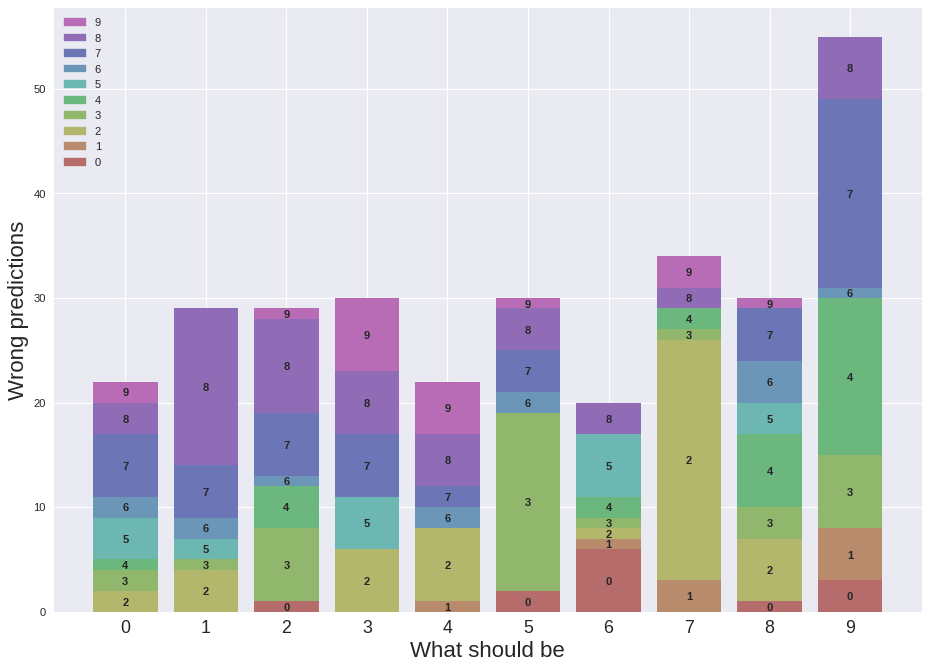

In [26]:
error_plot(decoded_mlp_predictions, expected)

From this chart we can see, that the most frequent errors are:
<ul>
<li>2 instead of 7</li>
<li>3 instead of 5</li>
<li>7 and 4 instead of 9</li>
<li>8 instead of 1, what isn't quite logical</li> 
</ul>


Now we're going to create more complex network, with two convolution layers. Convolution neural networks are slower, but are much more efficient on image recognition

In [64]:
cnn_model = Sequential([
    # input shape is (28, 28, 1), i.e. 28x28 pixels image with 1 color chanel (grayscale)
    
    # first convolution layer with 3x3 filters for extracting micro features
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.05),
    
    # second convolution layer with 5x5 filters for extracting macro features
    Conv2D(128, (3, 3), activation='relu', strides=(2,2)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.5),
    Dense(10, activation='softmax', kernel_initializer='random_uniform')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In order to apply 2D convolution, we have to convert our train samples into (28, 28, 1) tensors

In [65]:
cnnTrainX = trainX.reshape(train_samples, 28, 28, 1)
cnnTestX = testX.reshape(test_samples, 28, 28, 1)

In [66]:
cnn_model.fit(cnnTrainX, trainY, batch_size=50, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 56s - loss: 0.3662 - acc: 0.8868    
Epoch 2/10
60000/60000 [==============================] - 49s - loss: 0.1535 - acc: 0.9554    
Epoch 3/10
60000/60000 [==============================] - 51s - loss: 0.1162 - acc: 0.9656    
Epoch 4/10
60000/60000 [==============================] - 50s - loss: 0.1068 - acc: 0.9693    
Epoch 5/10
60000/60000 [==============================] - 52s - loss: 0.0943 - acc: 0.9725    
Epoch 6/10
60000/60000 [==============================] - 52s - loss: 0.0889 - acc: 0.9740    
Epoch 7/10
60000/60000 [==============================] - 52s - loss: 0.0799 - acc: 0.9768    
Epoch 8/10
60000/60000 [==============================] - 50s - loss: 0.0782 - acc: 0.9777    
Epoch 9/10
60000/60000 [==============================] - 55s - loss: 0.0745 - acc: 0.9784    
Epoch 10/10
60000/60000 [==============================] - 52s - loss: 0.0706 - acc: 0.9797    


Evaluating on test data

In [68]:
cnn_predictions = cnn_model.predict(cnnTestX)

decoded_cnn_predictions = decode_one_hot(cnn_predictions)
expected = testY.reshape(testY.shape[0])

print(evaluate_accuracy(decoded_cnn_predictions, expected))

model accuracy on test data: 98.800%


98.8% is significantly better result. It could come from CNN's ability to recognize spatial structure of images

Let's take a look at errors details

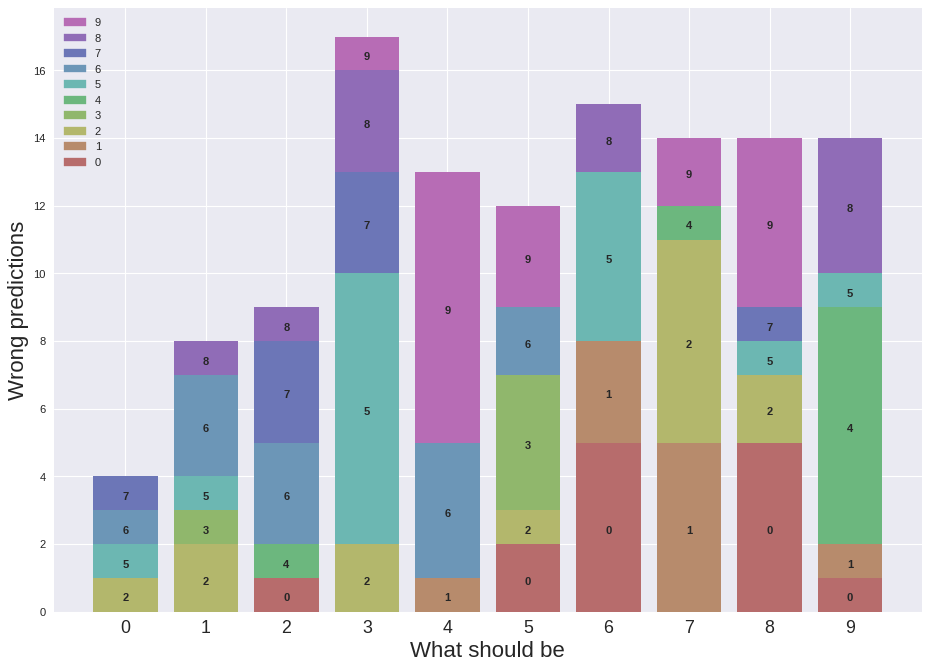

In [69]:
error_plot(decoded_cnn_predictions, expected)

Typical errors are:
* 5 instead of 3
* 9 instead of 4
* 0 and 5 instead of 6
* 1 and 2 instead of 7
* 0 and 9 instead of 9
* 4 instead of 9

This is much more like human could make a mistake, in opposite to simple MLP, which made a lot of errors like confusing 1 with 8 or 9 with 7